In [1]:
import pandas as pd
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import random as rnd
from functions import *

### Getting Dataset

In [2]:
x = get_x_data()

In [3]:
y = get_target()

In [4]:
y = pd.get_dummies(pd.DataFrame(y))

In [5]:
y = y.replace({True: 1, False: 0})

In [6]:
y = np.asarray(y)

### Data Augmentation Before Spltting

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.applications import resnet, densenet

2024-04-29 13:49:47.146163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 13:49:47.455154: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 13:49:47.495147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:49:47.

In [8]:
from tensorflow.keras.layers import RandomZoom, RandomContrast, RandomRotation

In [9]:
data_augmentation_layers = [
    RandomZoom((0.1, 0.5)),
    RandomRotation(0.5),
    RandomContrast(0.2)
]


def data_augmentation(imgs):
    for layer in data_augmentation_layers:
        imgs = layer(imgs)
    return imgs

In [10]:
augmented_x = data_augmentation(x)

2024-04-29 13:50:01.303448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 13:50:01.303882: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-29 13:50:01.303913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AB0NGOS5): /proc/driver/nvidia/version does not exist
2024-04-29 13:50:01.306752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(np.asarray(augmented_x), y, test_size = 0.3)

### DenseNetModel1

In [14]:
def densenet_model(input_shape):
    dn121 = DenseNet121(input_shape = input_shape, weights = 'imagenet', include_top = False,
                        pooling = 'avg')
    dn121.trainable = False
    
    inputs = Input(input_shape)
    x = densenet.preprocess_input(inputs)
    x = Dropout(0.3)(x)
    x = dn121(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'DenseNetModel')

In [14]:
dn_model = densenet_model(input_shape = (224, 224, 3))
dn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [15]:
dn_history = dn_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 24s 2s/step - loss: 1.6491 - accuracy: 0.3029 - val_loss: 1.6884 - val_accuracy: 0.4000
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 1.3033 - accuracy: 0.4886 - val_loss: 1.5581 - val_accuracy: 0.4467
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 1.0523 - accuracy: 0.6371 - val_loss: 1.4374 - val_accuracy: 0.4667
Epoch 4/10
11/11 [==============================] - 19s 2s/step - loss: 0.9321 - accuracy: 0.6571 - val_loss: 1.4339 - val_accuracy: 0.4733
Epoch 5/10
11/11 [==============================] - 20s 2s/step - loss: 0.8206 - accuracy: 0.7457 - val_loss: 1.3099 - val_accuracy: 0.5067
Epoch 6/10
11/11 [==============================] - 19s 2s/step - loss: 0.7251 - accuracy: 0.7857 - val_loss: 1.3519 - val_accuracy: 0.5067
Epoch 7/10
11/11 [==============================] - 19s 2s/step - loss: 0.6705 - accuracy: 0.7771 - val_loss: 1.1679 - val_accuracy: 0.5733
Epoch 8/10
11/11 [==

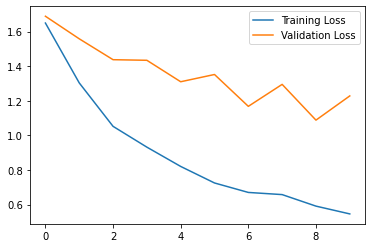

In [16]:
plt.plot(range(len(dn_history.history['loss'])), dn_history.history['loss'], label = 'Training Loss')
plt.plot(range(len(dn_history.history['val_loss'])), dn_history.history['val_loss'], label = 'Validation Loss')
plt.legend()

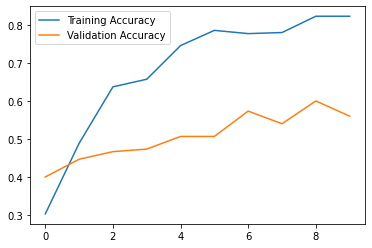

In [17]:
plt.plot(range(len(dn_history.history['accuracy'])), dn_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(dn_history.history['val_accuracy'])), dn_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

Training and Validation Accuracy and Loss diverge a lot.

### Testing a Second DenseNetModel

In [18]:
from keras import regularizers

In [19]:
def densenet_model2(input_shape):
    dn121 = DenseNet121(input_shape = input_shape, weights = 'imagenet', include_top = False,
                        pooling = 'avg')
    dn121.trainable = False
    
    inputs = Input(input_shape)
    x = densenet.preprocess_input(inputs)
    x = Dropout(0.3)(x)
    x = dn121(x)
    x  = Dense(512, kernel_regularizer = regularizers.L1(0.01))(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'DenseNetModel2')

In [20]:
dn_model2 = densenet_model2(input_shape = (224, 224, 3))
dn_model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
dn_history2 = dn_model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 21s 2s/step - loss: 148.2419 - accuracy: 0.4029 - val_loss: 127.2287 - val_accuracy: 0.2800
Epoch 2/10
11/11 [==============================] - 18s 2s/step - loss: 110.5542 - accuracy: 0.6571 - val_loss: 92.7523 - val_accuracy: 0.5400
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 79.2534 - accuracy: 0.7429 - val_loss: 64.6791 - val_accuracy: 0.6200
Epoch 4/10
11/11 [==============================] - 19s 2s/step - loss: 54.0800 - accuracy: 0.7114 - val_loss: 42.9146 - val_accuracy: 0.7400
Epoch 5/10
11/11 [==============================] - 19s 2s/step - loss: 35.3330 - accuracy: 0.8171 - val_loss: 28.1470 - val_accuracy: 0.6400
Epoch 6/10
11/11 [==============================] - 19s 2s/step - loss: 23.5577 - accuracy: 0.8371 - val_loss: 19.7429 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 19s 2s/step - loss: 16.5668 - accuracy: 0.8257 - val_loss: 13.8856 - val_accuracy: 0.6600
Epo

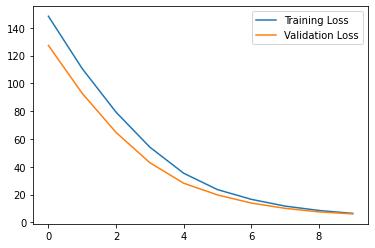

In [22]:
plt.plot(range(len(dn_history2.history['loss'])), dn_history2.history['loss'], label = 'Training Loss')
plt.plot(range(len(dn_history2.history['val_loss'])), dn_history2.history['val_loss'], label = 'Validation Loss')
plt.legend()

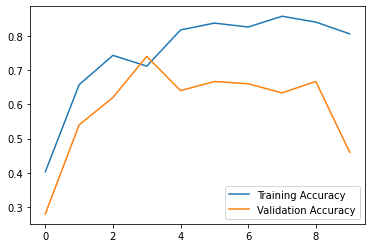

In [23]:
plt.plot(range(len(dn_history2.history['accuracy'])), dn_history2.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(dn_history2.history['val_accuracy'])), dn_history2.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

Peak performance with the regularizer was better, but final performance was worse.

In [16]:
from tensorflow.keras.metrics import AUC

In [17]:
def get_dn_model():
    dn_model = densenet_model(input_shape = (224, 224, 3))
    dn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [AUC(multi_label = True, num_labels = 5)])
    return dn_model

dn_model = get_dn_model()

dn_model.fit(x_test, y_test, epochs = 10)

dn_model.save('my_dn_model.keras')

Epoch 1/10
5/5 [==============================] - 9s 972ms/step - loss: 1.8340 - auc: 0.5203
Epoch 2/10
5/5 [==============================] - 5s 936ms/step - loss: 1.6537 - auc: 0.6001
Epoch 3/10
5/5 [==============================] - 5s 923ms/step - loss: 1.4286 - auc: 0.7108
Epoch 4/10
5/5 [==============================] - 5s 985ms/step - loss: 1.2853 - auc: 0.7774
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 1.1575 - auc: 0.8270
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 1.0699 - auc: 0.8637
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.9851 - auc: 0.8872
Epoch 8/10
5/5 [==============================] - 6s 1s/step - loss: 0.8695 - auc: 0.9234
Epoch 9/10
5/5 [==============================] - 6s 1s/step - loss: 0.8331 - auc: 0.9278
Epoch 10/10
5/5 [==============================] - 6s 1s/step - loss: 0.7717 - auc: 0.9443
